In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.svm import SVR

pd.options.mode.chained_assignment = None  # default='warn'

In [4]:
df = pd.read_csv('ratings_hm_25.csv')

In [5]:
df.head()

,Unnamed: 0,userId,movieId,rating,genres
0,0,1,1,4,Thriller
1,1,1,2,4,Drama
2,2,1,5,2,Drama|Thriller|War
3,3,1,6,4,Crime|Drama|Romance|Thriller
4,4,1,10,4,Animation|Children's|Comedy


In [6]:
df = df.drop(columns='Unnamed: 0')
df

,userId,movieId,rating,genres
0,1,1,4,Thriller
1,1,2,4,Drama
2,1,5,2,Drama|Thriller|War
3,1,6,4,Crime|Drama|Romance|Thriller
4,1,10,4,Animation|Children's|Comedy
...,...,...,...,...
10044,200,155,5,Drama|Mystery
10045,200,175,4,Sci-Fi|Thriller
10046,200,177,4,Comedy
10047,200,178,3,Drama|Romance


In [7]:
df['rating'][:15].to_numpy()

array([4, 4, 2, 4, 4, 5, 2, 3, 3, 4, 3, 4, 2, 5, 4])

In [8]:
def cut_ratings(ratings, min_rating = 1, max_rating = 5):
    if ratings < min_rating:
        ratings = min_rating
    elif ratings > max_rating:
        ratings = max_rating
    return ratings

df['rating'] = df['rating'].apply(cut_ratings)

In [9]:
class MF():

    def __init__(self, R, K, alpha, beta, iterations, is_with_bias=True, random_seed=1):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.

        Arguments
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """
        np.random.seed(random_seed)
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.is_with_bias = is_with_bias

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            #print(i)
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            mae = self.mae()
            training_process.append((i, mse))
            if (i+1) % 100 == 0:
                print("Iteration: %d ; error^2 = %.4f; RMSE = %.6f; ; abs(error) = %.4f; MAE = %.6f;" % (i+1, mse, mse / len(self.samples), mae, mae / len(self.samples)))

        return training_process

    def mae(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += abs(self.R[x, y] - predicted[x, y])
        return error

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            if self.is_with_bias:
                # Update biases
                self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
                self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)

In [10]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.1, random_state=1)
print(f'Train / test split = {len(train_df)}/{len(test_df)}')

Train / test split = 9044/1005


In [11]:
df_movie_features = train_df.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)
df_movie_features.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,191,192,193,194,195,196,197,198,199,200
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,4.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,4.0,...,0.0,4.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,5.0,4.0,0.0,0.0,0.0,0.0,...,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,2.0,...,0.0,5.0,0.0,1.0,0.0,4.0,5.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,4.0,3.0,0.0,4.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
5,0.0,0.0,2.0,3.0,2.0,2.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,5.0,0.0,0.0


In [12]:
R = df_movie_features.values
k = 100

In [13]:
mf = MF(R, K=k, alpha=0.001, beta=0.05, iterations=250, is_with_bias=False)
training_err_arr = mf.train()
full_matrix = mf.full_matrix()

Iteration: 100 ; error^2 = 102.9970; RMSE = 0.011388; ; abs(error) = 8163.5049; MAE = 0.902643;
Iteration: 200 ; error^2 = 93.3491; RMSE = 0.010322; ; abs(error) = 7318.2107; MAE = 0.809179;


In [14]:
training_err_arr[-5:]

[(245, 84.10374150325194),
 (246, 83.93856764228484),
 (247, 83.77451090133852),
 (248, 83.61141129704127),
 (249, 83.44933030977886)]

In [15]:
full_matrix[0].round(2)

array([3.49, 4.1 , 2.87, 2.93, 3.34, 3.79, 3.71, 4.03, 2.53, 3.7 , 3.98,
       3.92, 3.37, 4.21, 3.15, 3.38, 3.37, 1.8 , 2.61, 3.48, 4.18, 3.1 ,
       2.78, 3.82, 4.24, 2.06, 3.23, 3.62, 2.96, 3.05, 4.  , 3.39, 3.67,
       3.76, 2.98, 3.52, 3.91, 3.31, 3.8 , 3.82, 3.66, 3.28, 4.46, 3.08,
       3.51, 3.77, 3.11, 4.11, 3.77, 4.02, 3.77, 3.41, 3.08, 2.39, 3.29,
       3.32, 4.09, 2.96, 3.73, 3.81, 3.58, 3.92, 4.39, 3.11, 3.92, 3.34,
       3.54, 3.94, 3.58, 3.9 , 3.55, 3.05, 3.76, 2.62, 3.81, 3.3 , 2.94,
       4.15, 2.7 , 3.1 , 3.25, 3.67, 3.36, 3.3 , 2.42, 3.21, 4.42, 4.3 ,
       2.37, 3.25, 3.4 , 3.31, 3.61, 4.21, 4.11, 3.89, 3.32, 3.93, 4.08,
       4.06, 3.71, 3.69, 4.34, 4.09, 3.56, 4.17, 3.52, 3.39, 3.23, 3.72,
       3.08, 3.36, 3.92, 3.11, 2.73, 3.06, 3.16, 4.29, 3.5 , 4.56, 3.64,
       3.62, 3.16, 4.07, 3.47, 3.25, 4.13, 3.17, 3.89, 3.16, 4.28, 3.71,
       4.02, 3.18, 2.91, 3.1 , 4.06, 3.91, 3.92, 4.25, 3.72, 3.57, 4.38,
       3.71, 3.73, 3.28, 2.89, 3.15, 3.38, 3.6 , 4.

In [16]:
def splitting(x):
    y = x.split('|')
    return y

In [17]:
genres = df['genres'].apply(splitting)

In [18]:
df['genres'][:5]

0                        Thriller
1                           Drama
2              Drama|Thriller|War
3    Crime|Drama|Romance|Thriller
4     Animation|Children's|Comedy
Name: genres, dtype: object

In [19]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

res = pd.DataFrame(mlb.fit_transform(genres),
                   columns=mlb.classes_,
                   index=genres.index)

In [20]:
new_df = df.drop(['genres'], axis = 1)
new_df[:5]

,userId,movieId,rating
0,1,1,4
1,1,2,4
2,1,5,2
3,1,6,4
4,1,10,4


In [21]:
new_df = new_df.join(pd.DataFrame(
    res, 
    index=new_df.index, 
    columns=res.columns
))


In [22]:
new_df[:5]

,userId,movieId,rating,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,2,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,5,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,1,6,4,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
4,1,10,4,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
import math
X = new_df.drop(['rating'], axis = 1)
y = new_df['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [24]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False, verbose = 2):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=verbose
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [25]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
model = RandomForestClassifier()
param_grid = {
    'n_estimators': [400, 700, 1000],
    'max_depth': [15,20,25],
    'max_leaf_nodes': [50, 100, 200]
}

model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 param_grid, cv=5, scoring_fit='neg_root_mean_squared_error')

print(model.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
-1.1031103930423822


In [58]:
print(model.best_params_)

{'max_depth': 25, 'max_leaf_nodes': 50, 'n_estimators': 1000}


In [89]:
svc = svm.SVR()

grid = GridSearchCV(

estimator=SVR(kernel='rbf'),

param_grid={

'C': [1.1, 5.4, 170, 1001],

'epsilon': [0.0003, 0.0109, 0.019, 8, 0.2, 2],

'gamma': [0.7001, 0.001, 3.1]
        },
        cv=5, scoring='neg_root_mean_squared_error', verbose=0, n_jobs=-1)

grid.fit(X,y)

print("best parameters are: ", grid.best_params_)

best parameters are:  {'C': 5.4, 'epsilon': 0.019, 'gamma': 3.1}


In [90]:
print(grid.best_score_)

-1.0874681052325854


In [68]:
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
neigh = KNeighborsClassifier()
param_gridKNN = {
    'n_neighbors': [3, 4, 8, 10,12,14,16,17,18,19,20,22,24,26,28,30,32,34,36,38,40],
    'weights':['uniform', 'distance'],
    'metric':['euclidean', 'manhattan', 'minkowski']
}
neigh, predKN = algorithm_pipeline(X_train, X_test, y_train, y_test, neigh, 
                                 param_gridKNN, cv=5, scoring_fit='neg_root_mean_squared_error', verbose = 0)

print(neigh.best_score_)

-1.2032912850663613


In [91]:
print(neigh.best_params_)

{'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}


In [92]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD()

param_gridSVD = {'algorithm':['randomized'], 'n_components':[2],'n_iter':[3,4,5,6], 
                 'random_state':[0],'tol':[0,0.02,0.01]}

#svd, param_gridSVD = algorithm_pipeline(X_train, X_test, y_train, y_test, svd, 
#                                 param_gridSVD, cv=5, scoring_fit='neg_mean_squared_error', verbose = 0)

gs = GridSearchCV(
        estimator=svd,
        param_grid=param_gridSVD, 
        cv=5, 
        n_jobs=-1, 
        scoring='neg_mean_squared_error',
        verbose=0
    )
fitted_model = gs.fit(X_train, y_train)
print(fitted_model.best_score_)

nan


/home/yuriy/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [93]:
svd.get_params().keys()

dict_keys(['algorithm', 'n_components', 'n_iter', 'random_state', 'tol'])

In [94]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
model = RandomForestClassifier()
param_grid = {
    'n_estimators': [400, 700, 1000],
    'max_depth': [15,20,25],
    'max_leaf_nodes': [50, 100, 200]
}

model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 param_grid, cv=5, scoring_fit='neg_mean_absolute_error')

print(model.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
-0.7990942534133658


In [95]:
neighMAE = KNeighborsClassifier()
param_gridKNNMAE = {
    'n_neighbors': [3, 4, 8, 10,12,14,16,17,18,19,20,22,24,26,28,30,32,34,36,38,40],
    'weights':['uniform', 'distance'],
    'metric':['euclidean', 'manhattan', 'minkowski']
}
neighMAE, predKNMAE = algorithm_pipeline(X_train, X_test, y_train, y_test, neighMAE, 
                                 param_gridKNNMAE, cv=5, scoring_fit='neg_mean_absolute_error', verbose = 0)

print(neighMAE.best_score_)

-0.8864430306677036


In [96]:
svc = svm.SVR()

param_grid_full = {
    'C': [1.1, 5.4, 170, 1001],
    'epsilon': [0.0003, 0.007, 0.0109, 0.019, 0.14, 0.05, 8, 0.2, 3, 2, 7],
    'gamma': [0.7001, 0.008, 0.001, 3.1, 1, 1.3, 5]}

param_grid_optimized = {
    'C': [1.1, 5.4],
    'epsilon': [0.0003, 0.14, 2, 7],
    'gamma': [0.001, 0.7, 5]}

gridMAE = GridSearchCV(
    estimator=SVR(kernel='rbf'),
    param_grid=param_grid_optimized,
    cv=5, scoring='neg_mean_absolute_error', verbose=0, n_jobs=-1)

gridMAE.fit(X,y)

print("best parameters are: ", gridMAE.best_params_)
print(gridMAE.best_score_)

best parameters are:  {'C': 1.1, 'epsilon': 0.0003, 'gamma': 0.001}
-0.8896047474507484


### Conclusion: Aim of our model is to recommend similar items to user and it's preferable that scoring system penalizes mistakes more the bigger difference between actual score and predicted score so we will use RMSE and not MAE scoring metric

## Shilling attack detection

In [26]:
import matplotlib.pyplot as plt
attack_size=100
target_movie_id=45
df_target_movie=df[(df.movieId == target_movie_id)]

### creating fake users that will rate specific film as 5 out of 5, they will also vote average ratings on other films

In [28]:
def insert_random_attack(df_temp, target_movie_id, attack_size=50, target_rate=5):
    #target rating
    last_user_id=df_temp.loc[df_temp['userId'].idxmax()].userId
    for i in range(attack_size):
        new_row = {'userId':last_user_id+i,
                   'movieId':target_movie_id,
                   'rating':target_rate}
        df_temp = df_temp.append(new_row, ignore_index=True)
        #random fill iteam rating
        df_random_movies=df_temp.sample(frac = 0.01)
        movie_list=df_random_movies.movieId.unique().tolist()
        for movie_id in movie_list:
            if movie_id ==target_movie_id:
                continue
            mean_rate=df_temp[df_temp.movieId == movie_id].rating.mean()
            new_row = {'userId':last_user_id+i,
                       'movieId':movie_id,
                       'rating':int(mean_rate)}
            df_temp = df_temp.append(new_row, ignore_index=True)
    return df_temp

In [29]:
df_movie_mean = pd.DataFrame()
new_df=insert_random_attack(df, target_movie_id, attack_size)
df_movie_mean['movieId']=new_df.movieId.unique()

### adding users to our database

In [31]:
movie_mean_list=[]
number_of_rates=[]
for index, row in df_movie_mean.iterrows():
    movie_id=row['movieId']
    df_a=new_df[new_df.movieId==movie_id]
    mean=df_a["rating"].mean()
    movie_mean_list.append(mean)
    number_of_rates.append(df_a["rating"].count())
df_movie_mean['ratingMean']=movie_mean_list
df_movie_mean['ratingCount']=number_of_rates
df_movie_mean

,movieId,ratingMean,ratingCount
0,1.0,3.247863,117
1,2.0,3.517730,141
2,5.0,3.309735,113
3,6.0,3.438596,114
4,10.0,3.336000,125
...,...,...,...
195,111.0,3.078261,115
196,187.0,3.175676,74
197,114.0,3.052083,96
198,120.0,4.281553,103


In [32]:
df[-10:]

,userId,movieId,rating,genres
10039,200,134,2,Drama|Romance|War|Western
10040,200,144,4,Drama|Romance
10041,200,147,4,Comedy|Drama
10042,200,153,5,Drama|Romance
10043,200,154,3,Comedy
10044,200,155,5,Drama|Mystery
10045,200,175,4,Sci-Fi|Thriller
10046,200,177,4,Comedy
10047,200,178,3,Drama|Romance
10048,200,193,2,Drama|Sci-Fi


In [33]:
last_real_index=df.loc[df['userId'].idxmax()].userId
last_real_index

200

### marking fake users for algorith to train on

In [35]:
df_attributes = pd.DataFrame()
user_ids=new_df.userId.unique()
df_attributes['userId']=user_ids
df_attributes['isAttack']=0
df_attributes.loc[df_attributes['userId'] > last_real_index, 'isAttack'] = 1
df_attributes=df_attributes[-200:]
df_attributes

,userId,isAttack
99,100.0,0
100,101.0,0
101,102.0,0
102,103.0,0
103,104.0,0
...,...,...
294,295.0,1
295,296.0,1
296,297.0,1
297,298.0,1


In [36]:
def calculate_RDMA_x(df_user_x_rates):
    numerator=0
    for index, row in df_user_x_rates.iterrows():
        movie_row=df_movie_mean[df_movie_mean.movieId == row['movieId']]
        Rxi=movie_row.iloc[0]['ratingCount']
        ri_mean=movie_row.iloc[0]['ratingMean']
        rxi=row['rating']
        sigma_numerator=abs(rxi-ri_mean)/Rxi
        numerator+=sigma_numerator
    Nx=len(df_attributes)
    RDMAx=numerator/Nx
    return RDMAx

In [37]:
RDMAx_list=[]
for index, row in df_attributes.iterrows():
    user_x_id=row['userId']
    df_user_x_rates=new_df[new_df.userId==user_x_id]
    RDMAx=calculate_RDMA_x(df_user_x_rates)
    RDMAx_list.append(RDMAx)

In [38]:
df_attributes['RDMA']=RDMAx_list
df_attributes

,userId,isAttack,RDMA
99,100.0,0,0.002406
100,101.0,0,0.001951
101,102.0,0,0.001362
102,103.0,0,0.002428
103,104.0,0,0.002562
...,...,...,...
294,295.0,1,0.001509
295,296.0,1,0.001596
296,297.0,1,0.001622
297,298.0,1,0.001613


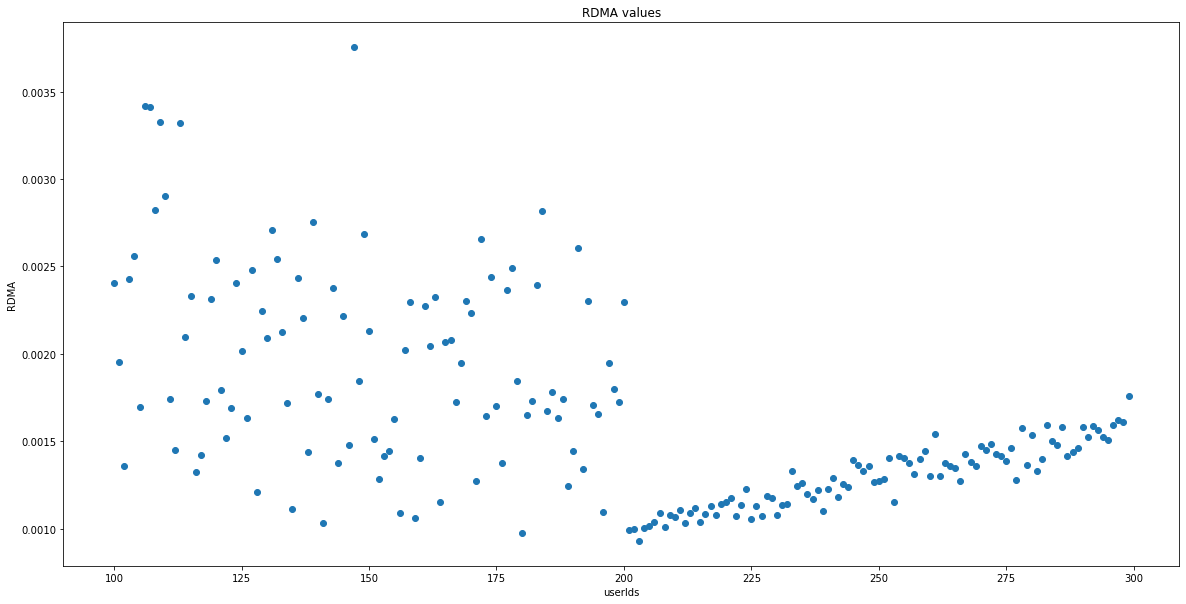

In [39]:
plt.figure(figsize=(20,10))
plt.scatter(df_attributes['userId'],df_attributes['RDMA'])
plt.title('RDMA values')
plt.xlabel('userIds')
plt.ylabel('RDMA')
plt.show()

In [40]:
final = pd.pivot_table(new_df,values='rating',index='userId',columns='movieId')
final.head()

movieId,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,191.0,192.0,193.0,194.0,195.0,196.0,197.0,198.0,199.0,200.0
userId,,,,,,,,,,,,,,,,,,,,,
1.0,4.0,4.0,NaN,NaN,2.0,4.0,NaN,NaN,NaN,4.0,...,NaN,4.0,NaN,NaN,NaN,1.0,4.0,NaN,NaN,NaN
2.0,NaN,NaN,NaN,NaN,5.0,4.0,NaN,NaN,NaN,NaN,...,3.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,2.0,...,NaN,5.0,NaN,1.0,NaN,4.0,5.0,NaN,NaN,NaN
4.0,NaN,NaN,NaN,NaN,4.0,3.0,NaN,4.0,NaN,5.0,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN
5.0,NaN,NaN,2.0,3.0,2.0,2.0,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,5.0,NaN,NaN


In [41]:
final_user = final.apply(lambda row: row.fillna(row.mean()), axis=1)
final_movie = final.fillna(0)

### calculating peason correlation for final_movie and final_user, final movie all unknown values are filled with zero, for final user all unknown are filled with user mean voting  

In [42]:
pearson = np.corrcoef(final_movie)
np.fill_diagonal(pearson, 1)
similarity_with_movie = pd.DataFrame(pearson,index=final_movie.index)
similarity_with_movie.columns=final_movie.index
similarity_with_movie.head()

userId,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,290.0,291.0,292.0,293.0,294.0,295.0,296.0,297.0,298.0,299.0
userId,,,,,,,,,,,,,,,,,,,,,
1.0,1.000000,0.061548,0.137668,-0.170908,0.028311,-0.085017,-0.128940,0.132410,-0.149600,0.075164,...,0.151502,0.014314,0.080950,-0.006887,0.008244,0.112739,0.008103,0.122820,-0.078712,0.054233
2.0,0.061548,1.000000,0.216084,0.118563,0.037807,0.047725,0.054285,0.004141,0.094236,0.064823,...,-0.029544,-0.069898,0.075527,0.028396,0.003096,-0.047654,-0.032494,-0.000815,-0.154779,-0.036684
3.0,0.137668,0.216084,1.000000,-0.046155,0.031453,0.009687,0.058833,0.022021,-0.140802,0.131540,...,-0.057583,0.047010,-0.017930,-0.085409,0.043809,-0.105153,-0.183836,-0.068952,0.020110,-0.044222
4.0,-0.170908,0.118563,-0.046155,1.000000,-0.161626,0.128865,0.064105,-0.011882,0.151744,-0.057966,...,-0.057449,0.021396,0.003393,-0.100197,-0.076057,-0.079396,-0.061988,-0.046830,0.036367,0.090736
5.0,0.028311,0.037807,0.031453,-0.161626,1.000000,-0.066974,0.049980,-0.106091,-0.010735,0.038906,...,0.022318,0.043092,-0.017873,-0.008672,-0.011675,0.000091,-0.104379,0.004590,-0.169929,-0.097954


In [43]:
b = np.corrcoef(final_user)
np.fill_diagonal(b, 0)
similarity_with_user = pd.DataFrame(b,index=final_user.index)
similarity_with_user.columns=final_user.index
similarity_with_user.head()

userId,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,290.0,291.0,292.0,293.0,294.0,295.0,296.0,297.0,298.0,299.0
userId,,,,,,,,,,,,,,,,,,,,,
1.0,0.000000,0.032542,0.037206,-0.007005,-0.019066,-0.083939,0.027582,0.088970,-0.014999,0.116036,...,0.182090,0.133429,0.154071,0.146430,0.174669,0.208870,0.179348,0.117684,0.070056,0.130521
2.0,0.032542,0.000000,0.209622,0.050813,-0.023683,0.053117,0.014022,0.075394,0.123199,0.052053,...,0.181090,0.140516,0.168137,0.186810,0.156302,0.170533,0.190226,0.085580,0.169219,0.169343
3.0,0.037206,0.209622,0.000000,-0.010251,-0.019285,0.054195,0.011227,0.016327,-0.132468,-0.011179,...,0.154414,0.220522,0.182156,0.128366,0.081833,0.133207,0.200384,0.050334,0.155712,0.155345
4.0,-0.007005,0.050813,-0.010251,0.000000,-0.077657,-0.090584,-0.049703,0.024480,0.086221,-0.000542,...,-0.002844,0.083266,-0.025734,-0.048459,-0.035720,-0.014207,-0.006363,-0.035274,0.024774,0.051724
5.0,-0.019066,-0.023683,-0.019285,-0.077657,0.000000,-0.029954,0.011512,0.058216,0.004230,0.120553,...,0.116559,0.052781,0.051075,0.077932,0.136746,0.062420,0.097218,0.112180,0.074125,0.104429


### find five closest neighbors for each user

In [44]:
def find_n_neighbours(df,n):
    order = np.argsort(df.values, axis=1)[:, :n]
    df = df.apply(lambda x: pd.Series(x.sort_values(ascending=False)
           .iloc[:n].index, 
          index=['top{}'.format(i) for i in range(1, n+1)]), axis=1)
    return df

In [45]:
sim_user_5_m = find_n_neighbours(similarity_with_movie,5)
sim_user_5_m.head()

,top1,top2,top3,top4,top5
userId,,,,,
1.0,1.0,51.0,24.0,114.0,80.0
2.0,2.0,171.0,102.0,145.0,3.0
3.0,3.0,61.0,145.0,170.0,57.0
4.0,4.0,191.0,160.0,27.0,192.0
5.0,5.0,51.0,97.0,155.0,79.0


## calculating average degree of similarity for each user 

In [46]:
similarity_df=similarity_with_movie
DegSim_list=[]
for index, row in df_attributes.iterrows():
    user_id=row['userId']
    sim_users=sim_user_5_m.iloc[int(user_id)-1]
    k=len(sim_users)
    sum_similarity=0
    for sim_user_id in sim_users:
        sum_similarity+=similarity_df[user_id][sim_user_id]
    DegSim=sum_similarity/k
    DegSim_list.append(DegSim)

In [47]:
df_attributes['DegSim']=DegSim_list

Text(0, 0.5, 'DegSim')

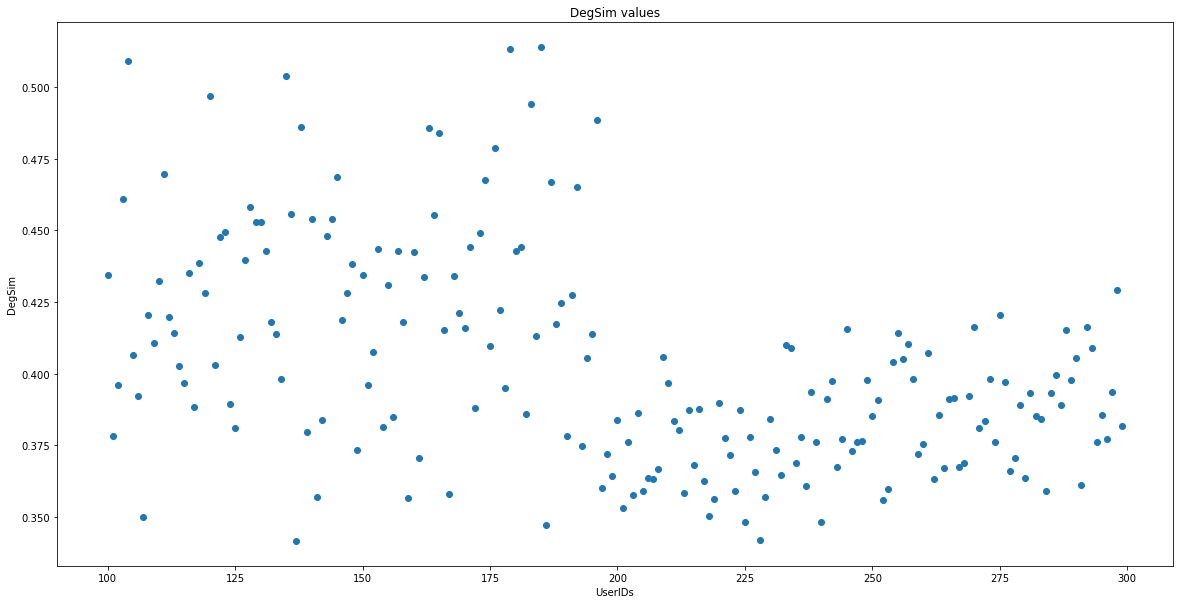

In [48]:
plt.figure(figsize=(20,10))
plt.scatter(df_attributes['userId'],df_attributes['DegSim'])
plt.title('DegSim values')
plt.xlabel('UserIDs')
plt.ylabel('DegSim')

In [74]:
features = df_attributes[['RDMA'] + ['DegSim']]

In [76]:
labels = df_attributes[['isAttack']]

## using RDMA and DegSim aqcuired to train KNN and Random Forest algorithms to find malicious users 

In [78]:
train, test, train_labels, test_labels = train_test_split(features,labels,test_size=0.33,random_state=42)

In [79]:
neigh = KNeighborsClassifier()
param_gridKNN = {
    'n_neighbors': [3, 4, 5,6,7,8,9,10],
    'weights':['uniform', 'distance'],
    'metric':['euclidean', 'manhattan', 'minkowski']
}
neigh, predKN = algorithm_pipeline(train, test, train_labels.values.ravel(), test_labels.values.ravel(), neigh, 
                                 param_gridKNN, cv=5, scoring_fit='accuracy')

print(neigh.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
0.7686609686609687


In [80]:
model = RandomForestClassifier()
param_grid = {
    'n_estimators': [5, 10, 20, 30,40],
    'max_depth': [15,20,25],
    'max_leaf_nodes': [50, 100, 200]
}

model, pred = algorithm_pipeline(train, test, train_labels.values.ravel(), test_labels.values.ravel(), model, 
                                 param_grid, cv=5, scoring_fit='accuracy')

Fitting 5 folds for each of 45 candidates, totalling 225 fits


In [81]:
print(model.best_score_)

0.9105413105413106


## Conclusion: it's possibe to detect shilling attack that's using mean votes on other films to give them degree of authenticity through RDMA and finding similarity between users. This approach has high accuracy ratings both through KNN and Random Forest algorithms although crossvalidation shows us that Random Forest is more useful. It's possible that clustering users based on their overall voting preferences and detecting malicious users by those clusters could prove to be a viable solutions too    